# Otimização de Resistência ao Avanço de Pontão

## 1. Introdução <a name="1"></a>

Neste relatório, abordamos uma jornada rumo ao aprimoramento de nossas habilidades em engenharia e design de sistemas oceânicos, guiados pelos ensinamentos e pela visão holística do Professor Richard Schachter, cuja expertise nos permitiu transcender a compreensão convencional de otimização no âmbito de Projetos de Sistemas Oceânicos 3. Sob a luz de sua orientação, fomos desafiados a repensar a forma como abordamos o projeto e a otimização de embarcações, com o objetivo de não apenas atingir soluções eficientes para casos específicos, mas, através do entendimento da metodologia proposta, buscar extrair princípios universais aplicáveis a uma ampla gama de desafios de engenharia - naval, principalmente.

## 2. Enunciado <a name="2"></a>
O enunciado do exercício proposto em aula no dia 05/04/2024 consistiu no seguinte texto: <br />
<i>"Organize o processo de projeto (com todas as fórmulas) para o dimensionamento de um pontão otimizado a ser rebocado a 8kn em rios largos e profundos, sem vento ou correnteza, de volume total de 1200 $m^3$ com menor resistência ao avanço possível, respeitando todas as restrições. Fazer fluxograma iterativo com todos os fatores de projeto com nomes e encadeados (sequência, iterações, interações), com todos os parâmetros e fórmulas do projeto."</i>

E as seguintes restrições foram especificadas:
$$\frac{L}{D} >= 14$$
$${\nabla}= 30m^3$$ 
$$ GM >= 1m$$

Sendo $L$ o comprimento do navio, $B$ sua boca, $D$ seu pontal, $T$ seu calado, $\nabla$ seu volume submerso e $GM$ a altura metacêntrica.

## 3. Fluxograma Interativo de Projeto <a name="3"></a>

Escrever e anexar imagem do fluxograma

## 4. Módulos Computacionais <a name="4"></a>

Para que a organização do processo de projeto elucidada no fluxograma iterativo seja, em última análise, implementada como um algoritmo de otimização em Python, é necessário definir as fórmulas e parâmetros que regem o dimensionamento do pontão. A seguir, apresenta-se as equações e variáveis que compõem o modelo computacional proposto - e a implementação dos fatores de projeto como módulos computacionais reutilizáveis.

Quando necessário, faz-se a distinção entre equações do tipo "geral" e "modelo", sendo as primeiras aplicáveis a qualquer tipo de embarcação, e as segundas, restritas ao projeto em questão (no caso, de um pontão).


### Variáveis Gerais

In [140]:
model_Vs = 8/1.944 # Velocidade de serviço do pontal, em m/s

### Modelo Físico

#### Modelo

In [141]:
# Constantes
model_g = 9.805  # Aceleração gravitacional na superfície terrestre, em m/s^2
model_p = 1025  # Densidade da água salgada, em kg/m^3
model_v = 1.14*(10**-6) # Viscosidade cinemática da água salgada em m^2/s

### Forma

In [142]:
def get_Cb(nabla: float, L: float, B: float, T: float):
    # Coeficiente de Bloco
    # nabla: volume submerso
    # L: comprimento
    # B: boca
    # T: calado
    return nabla/(L*B*T)
    

#### Modelo

In [143]:
def get_model_volume(L: float, B: float, D: float):
    # Volume
    # L: comprimento
    # B: boca
    # T: calado
    return L*B*D

def get_model_underwater_volume(L: float, B: float, T: float) -> float:
  # Volume submerso de pontal
  return L*B*T

def get_model_Sw(L: float, B: float, T: float):
    # Área molhada de pontal
    return 2*(L*T) + B*L + 2*(B*T)

def get_model_Ix(L: float, B: float, T: float):
    # Momento de inércia longitudinal
    return (1/12)*L*(B**3)

def get_model_Cp(Cb: float):
    # Coeficiente prismático
    # Cb: Coeficiente de Bloco
    # TODO: existe uma fórmula mais confiável para um pontal?
    return 0.990 * Cb

def get_model_k(L: float, B: float, Cb: float):
    # Fator de forma
    # Fórmula de Conn e Ferguson
    # TODO: existe uma fórmula mais confiável para um pontal?
    return 18.7*((Cb*B/L)**2)

### Establidade

In [144]:
def get_BM(Ix: float, nabla: float) -> float:
  # Raio metacêntrico
  # Ix: Momento de inércia longitudinal
  # nabla: Volume submerso
  return Ix/nabla

def get_GM(KB: float, BM: float, KG: float) -> float:
  # Altura Metacêntrica
  # KB: Altura do centro de carena
  # BM: Raio metacêntrico
  # KG: Altura do centro de gravidade vertical
  return KB + BM - KG

#### Modelo

In [145]:
def get_model_KB(T: float) -> float:
  # Altura do centro de carena
  return T/2

def get_model_BM(L: float, B: float, T: float) -> float:
  # Raio metacêntrico
  return get_BM(
    Ix=get_model_Ix(L=L, B=B, T=T),
    nabla=get_model_underwater_volume(L=L, B=B, T=T)
  )

### Peso

#### Modelo

In [146]:
model_Faa = 0.11 # Fator de aço

def get_model_lightweight(L: float, B: float, D: float) -> float:
  # Peso leve
  # L: comprimento
  # B: boca
  # D: calado
  return model_Faa * get_model_volume(L=L, B=B, D=D)

def get_model_KG(D: float) -> float:
  # Altura do centro de gravidade vertical
  return D/2

### Resistência ao Avanço

In [147]:
from math import sqrt

def get_Rt(p: float, Sw: float, V: float, Ct: float):
    # Resistência total
    # p = densidade volumétrica do fluido
    # Sw = área molhada
    # V = velocidade
    # C = coeficiente de resistência total
    return (1/2)*p*Sw*(V**2)*Ct

def get_Re(L: float, V: float, p: float, v: float):
    # Número de Reynolds
    # L: comprimento do navio
    # V: velocidade do navio
    # p: densidade do fluido
    # v: viscosidade cinemática do fluido
    return (V*L/v)

def get_Fn(L: float, V: float, g: float):
    # Número de Froude
    # L: comprimento
    # V: velocidade
    # g: aceleração da gravidade
    return V/sqrt(g*L)


#### Modelo

Para o modelo proposto, utiliza-se uma adaptação do Método de previsão de desempenho ITTC1978.

In [148]:
from math import log10

def get_model_Cf(L: float, V: float, p: float, v: float):
    # Coeficiente de resistência friccional
    # L: comprimento
    # V: velocidade
    # p: densidade do fluido
    # v: viscosidade cinemática do fluido
    
    Re = get_Re(L, V, p, v)
    return 0.075/ (log10(Re) - 2)**2

def get_model_Ct(k: float, Cf: float, Cr: float, delta_Cf: float, Caa: float):
    # Coeficiente de resistência total
    return (1+k)*Cf + Cr + delta_Cf + Caa

def get_model_Cr(L: float, B: float, T: float, nabla: float, Cp: float, V: float, g: float):
    # Coeficiente de resistência residual
    # L: comprimento
    # B: boca
    # T: calado
    # nabla: volume submerso
    # Cp: coeficiente prismático
    # V: velocidade

    Fn = get_Fn(L, V, g=g)
    SLX = 3.3613*Fn + Cp - 0.7
    CRB = -1.83 + 14.02*SLX - 27*(SLX**2) + 18.32*(SLX**3)
    return (CRB + 0.12*(B/T-3) + 50*(nabla/(L**3) - 0.007))/1000

def get_model_deltaCf(L: float):
    # Tolerância de rugosidade
    # L: comprimento
    return (105*(((150*(10**-6))/L)**(1/3)) - 0.64) * (10**-3)

def get_model_Caa(B: float, D: float, T: float, Sw: float):
    # Coeficiente de resistência do ar
    # B: boca
    # D: pontal
    # T: calado
    # Sw: área molhada

    At = B*(D-T)*0.8  # Área transversal acima da linha d'água
    return 0.001*At/Sw

## 5. Otimização <a name="5"></a>

Então procede-se para otmização em Python. Para a aplicação no contexto vigente, pode-se sumarizar o entendimento da otimização como a implementação de uma rotina que espera três (03) parâmetros como input:

1. **bounds**: uma lista de limites (máximos e mínimos) para os possíveis valores dos parâmetros alterados ao longo da otimização;
2. **constraints**: uma lista de dicionários representando restrições para os possíveis valores dos parâmetros alterados ao longo da otimização;
3. **fun**: uma função que calcula e retorna o valor a ser otimizado;

Em termos matemáticos, a função de otimização resolve o seguinte problema:

<br />
<img src="./images/minimize_function.png" width="500" /> 
<br />

Onde $F(x)$ corresponde ao parâmetro **fun**; $X$ corresponde ao vetor de parâmetros, cuja ordem dos elementos vem da ordem definida pelos limites do parâmetro **bounds**;  $C_j(X) = 0$ é uma restrição de igualdade e $C_j(X) >= 0$ uma restrição de desigualdade, que são definidas no parâmetro **constraints**; e $XL <= x <= XU$ é um conjunto de limites (L sendo o limite inferior e U o limite superior), que são definidos no parâmetro **bounds**.

Seguindo a ordem da explicação dos parâmetros dada acima, a seguir desenvolve-se o passo-a-passo para configuração do ambiente de Python e definição do que é esperado para cada parâmetro.

### 5.1 Configuração do Ambiente  <a name="5.1"></a>

Para aplicar a otimização, utiliza-se algoritmos da biblioteca Scipy do Python. Caso encontre algum erro indicando a necessidade de se instalar a biblioteca Scipy após execução desse notebook, descomente e execute as últimas linhas da cédula abaixo para instalar a biblioteca.

In [149]:
# O módulo sys fornece várias funções e variáveis que são usadas para manipular
# diferentes partes do ambiente de execução do Python.
# Isso fornece uma maneira mais segura de instalar pacotes.

# import sys
# !{sys.executable} -m pip install scipy
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install matplotlib

E define-se o tipo do vetor de otimização:

In [150]:
# L, B, D, T
type X = tuple[float, float, float, float]

### 3.2 Limites | bounds  <a name="3.2"></a>

Define-se uma sequência de tuplas, cada uma representando um limite do tipo $L <= x <= U$. Nota-se que a ordem dos limites define a ordem dos parâmetros alterados no vetor de resultados. 

In [151]:
def build_bounds():
    '''Uma função que define limites (inferior e superior) para cada parâmetro
    a ser alterado ao longo da otimização.


    Retorna
    -------
    out : sequence, tup
        Sequência de tuplas, cada uma representando um limite mínimo e máximo
        para um parâmetro específico.
        

    Notas
    -----
    A ordem dos dicionários com limites retornados deve seguir a ordem correspondente
    dos parâmetros definidos no vetor de chute inicial (x0). O valor "None" representa
    a ausência de um máximo ou mínimo.
    '''

    L_bound = (0, 10000)
    B_bound = (0, 100)
    D_bound = (0, 100)
    T_bound = (0, 20)
    return (
        L_bound,
        B_bound,
        D_bound,
        T_bound
    )

### 3.3 Restrições | constraints  <a name="3.3"></a>

Define-se uma sequência de dicionários em Python, cada um representando uma restrição do tipo $C_j(X) >= 0$ (nesse caso, estamos lidando apenas com desigualdades) e cada dicionário contendo as chaves **"type"** (para definir se a restrição é uma igualdade ou desigualdade) e **"func"** (definindo a restrição em si). Nesse caso, a ordem das restrições definidas na sequência deve ser coerente com a ordem das restrições passadas pelo argumento **bounds** anteriormente definido.

In [152]:
def build_constraints():
    '''Uma função que constrói restrições relacionando dois ou mais parâmetros
    ou limites que devem ser calculados a partir do conjunto de parâmetros x.


    Retorna
    -------
    out : sequence, dict
        Sequência de dicionários, cada um representando uma restrição específica, 
        contendo as chaves "type" e "fun".

        "type" : {"eq", "ineq"}
            Determina se a restrição é uma igualdade ou desigualdade.

        "fun" : callable
            A função definindo a restrição. Recebe o vetor de parâmetros x de
            determinada iteração (na ordem definida pelo vetor inicial x0).
            Restrições de igualdade significam que o resultado da função "fun"
            deve ser 0 (fun(x) == 0) enquanto que restrições de desigualdade 
            significam que o resultado deve ser não-negativo (fun(x) >= 0).
            
            
    Ver também
    --------
    https://stackoverflow.com/questions/42303470/scipy-optimize-inequality-constraint-which-side-of-the-inequality-is-considere/42304099

    Notas
    -----
    Restrições tipicamente não necessitam de uma função "build" para serem definidas,
    sendo geralmente mais sucintamente definidas com "func" sendo uma função anônima 
    (lambda). A decisão de criar a função "build_constraints" foi baseada no objetivo
    de aumentar a legibilidade do código e esclarecer onde cada restrição do problema
    foi definida.
    '''

    def get_volume_constraint(x: X):
        '''V = 1200'''
        L, B, D = x[0], x[1], x[2]
        return get_model_volume(L=L, B=B, D=D) - 1200 # == 0

    def get_underwater_volume_constraint(x: X):
        '''nabla = 30'''
        L, B, T = x[0], x[1], x[3]
        return get_model_underwater_volume(L=L, B=B, T=T) - 30 # == 0
    
    def get_L_over_D_constraint(x: X):
        '''L/D >= 14'''
        L, D = x[0], x[2]
        return L/D - 14 # >= 0

    def get_GM_constraint(x: X):
        '''GM >= 1'''
        L, B, D, T = x[0], x[1], x[2], x[3]
        KB = get_model_KB(T=T)
        BM = get_model_BM(L=L, B=B, T=T)
        KG = get_model_KG(D=D)
        return get_GM(KB=KB, BM=BM, KG=KG) - 1  # >= 0
    
    def get_weight_constraint(x: X):
        '''Navio não afunda'''
        L, B, D = x[0], x[1], x[2]
        W = get_model_lightweight(L=L, B=B, D=D)
        T_calculated_from_weight = W / (B * L)
        return D - T_calculated_from_weight  # >= 0
    
    # Outras restrições
    # Coeficientes de resistência
    def Cf_constraint(x: X):
        '''Cf >= 0'''
        L = x[0]
        return get_model_Cf(L=L, V=model_Vs, p=model_p, v=model_v)  # >= 0
    
    def Cr_constraint(x: X):
        '''Cr >= 0'''
        L, B, T = x[0], x[1], x[3]
        nabla = get_model_underwater_volume(L=L, B=B, T=T)
        Cp = get_model_Cp(Cb=get_Cb(nabla=nabla, L=L, B=B, T=T))
        return get_model_Cr(L=L, B=B, T=T, nabla=nabla, Cp=Cp, V=model_Vs, g=model_g)  # >= 0
    
    def deltaCf_constraint(x: X):
        '''deltaCf >= 0'''
        L = x[0]
        return get_model_deltaCf(L=L)  # >= 0
    
    def Caa_constraint(x: X):
        '''Caa >= 0'''
        L, B, D, T = x[0], x[1], x[2], x[3]
        Sw = get_model_Sw(L, B, D)
        return get_model_Caa(B=B, D=D, T=T, Sw=Sw)  # >= 0
    

    return (
        # Principais restrições
        {'type': 'eq', 'fun': get_volume_constraint},
        {'type': 'eq', 'fun': get_underwater_volume_constraint},
        {'type': 'ineq', 'fun': get_L_over_D_constraint},
        {'type': 'ineq', 'fun': get_GM_constraint},
        {'type': 'ineq', 'fun': get_weight_constraint},
        
        # Outras restrições
        {'type': 'ineq', 'fun': Cf_constraint},
        {'type': 'ineq', 'fun': Cr_constraint},
        {'type': 'ineq', 'fun': deltaCf_constraint},
        {'type': 'ineq', 'fun': Caa_constraint}
    )

### 3.4 Função Objetivo | func  <a name="3.4"></a>

Uma função que, a partir de um conjunto de parâmetros que podem ser alterados (dentro das restrições e limites definidos anteriormente), retorna o valor calculado do coeficiente de resistência total, que é o que em última análise buscamos minimizar.

In [153]:
def objective_function(x: X):
    '''Uma função que calcula o valor a ser otimizado a partir das fórmulas
    do modelo computacional proposto, calculadas a partir do conjunto de parâmetros que podem ser
    alterados ao longo da otimização.

    Parâmetros
    -------
    x : list
        Uma lista de parâmetros, cuja ordem segue a ordem definida para
        o vetor de chute inicial (x0)

    Retorna
    -------
    out : float
        O valor otimizado, calculado a partir dos parâmetros da função
    '''
    L, B, D, T = x
    
    # Volume submerso
    nabla = get_model_underwater_volume(L=L, B=B, T=T)

    # Coefiente de bloco
    Cb = get_Cb(nabla=nabla, L=L, B=B, T=T)

    # Área molhada
    Sw = get_model_Sw(L=L, B=B, T=T)

    # Coeficiente de resistência total
    Ct = get_model_Ct(
        k=get_model_k(L=L, B=B, Cb=Cb), # Fator de forma
        Cf=get_model_Cf(L=L, V=model_Vs, p=model_p, v=model_v), # Coeficiente de resistência friccional
        Cr=get_model_Cr(nabla=nabla, L=L, B=B, T=T, Cp=get_model_Cp(Cb=Cb), V=model_Vs, g=model_g), # Coeficiente de resistência residual
        delta_Cf=get_model_deltaCf(L=L), # Tolerância de rugosidade
        Caa=get_model_Caa(B=B, D=D, T=T, Sw=Sw) # Coeficiente de resistência do ar
    )

    # Resistência total
    return get_Rt(
        p=model_p, # Densidade do fluido
        Sw=Sw, # Área molhada
        V=model_Vs, # Velocidade
        Ct=Ct # Coeficiente de resistência total
    )

### 3.5 Execução  <a name="3.5"></a>

Finalmente, utiliza-se os valores desenvolvidos acima como argumentos para cada parâmetro da função de otimização.

In [154]:
from scipy.optimize import minimize, shgo # type: ignore
# from typing import cast

# Variáveis livres iniciais

L0 = 80

# L/D >= 14
D0 = L0/14

# LBD = 1200. Logo, B = 1200/(L*D)
B0 = 1200/(L0*D0)

# LBD = 1200 e LBT = 30. Logo, D/T = 30 -> T = 30/D
T0 = 30/D0

XO: X = (L0, B0, D0, T0)  

type XAndFunResults = list[list[float]]
x_and_fun_results: XAndFunResults = []
def callback(intermediate_x: X):
    fun = objective_function(intermediate_x)
    result = [intermediate_x[0], intermediate_x[1], intermediate_x[2], intermediate_x[3], fun]
    x_and_fun_results.append(result)


_ = minimize(
    x0=XO,
    fun=objective_function,
    bounds=build_bounds(),
    constraints=build_constraints(),
    method='SLSQP',
    options={'disp': True},
    callback=callback
)


C:\Users\Leonardo\AppData\Local\Temp\ipykernel_15980\3702488339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return nabla/(L*B*T)
C:\Users\Leonardo\AppData\Local\Temp\ipykernel_15980\2287043928.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return (CRB + 0.12*(B/T-3) + 50*(nabla/(L**3) - 0.007))/1000
C:\Users\Leonardo\AppData\Local\Temp\ipykernel_15980\2187824072.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  return Ix/nabla


Optimization terminated successfully    (Exit mode 0)
            Current function value: 10743.737938599312
            Iterations: 20
            Function evaluations: 113
            Gradient evaluations: 20


### 3.6 Resultados  <a name="3.6"></a>

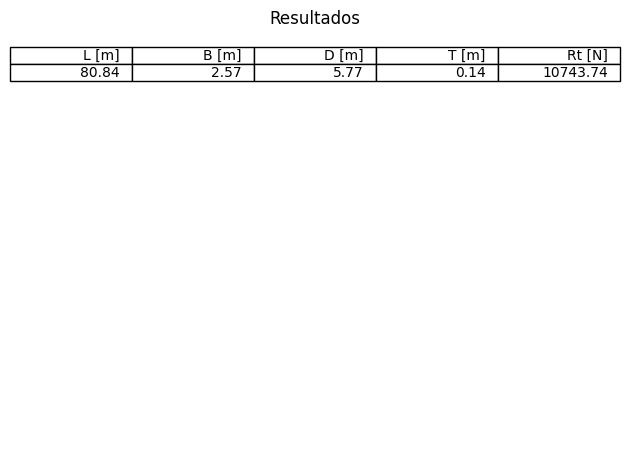

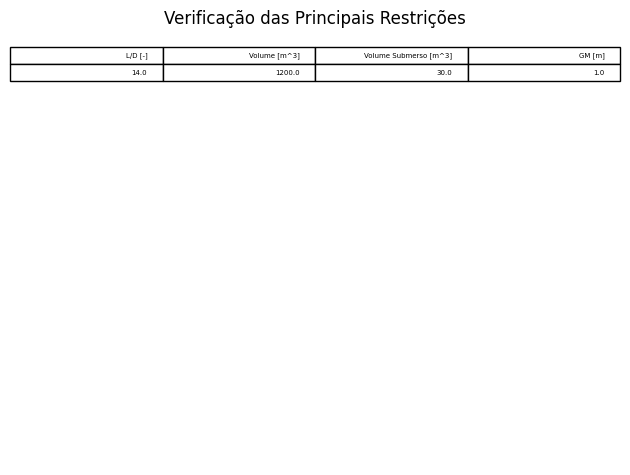

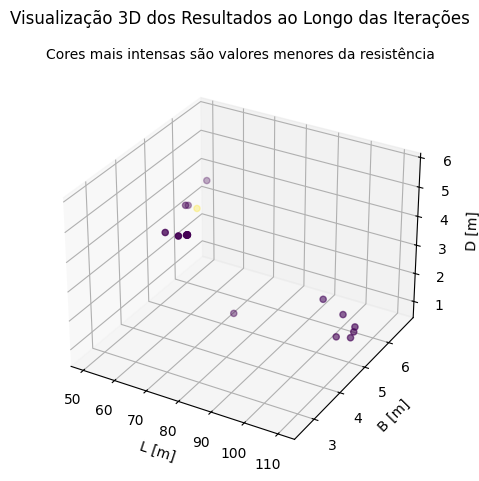

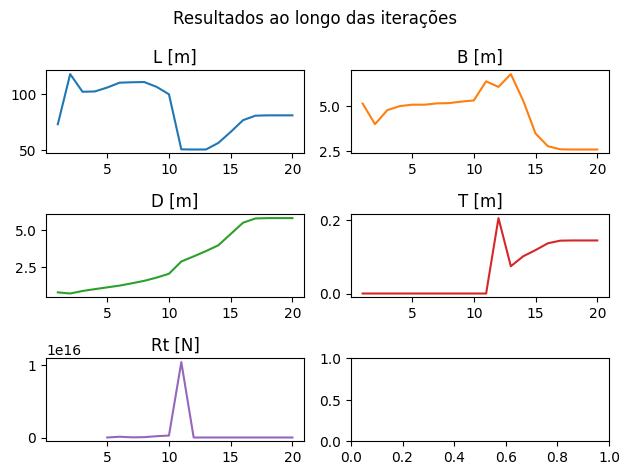

In [164]:
# type: ignore

import matplotlib.pyplot as plt

def plot_results(x: XAndFunResults):
    L, B, D, T, fun = x[-1] 

    # 1. Plot tabela com resultados
    Rt = fun
    fig, ax = plt.subplots()
    fig.suptitle('Resultados')
    ax.axis('off')
    table_data = [
        ['L [m]', 'B [m]', 'D [m]', 'T [m]', 'Rt [N]'],
        [round(val, 2) for val in [L, B, D, T, Rt]]
    ]

    ax.table(cellText=table_data, loc='top')
    fig.tight_layout()
    plt.show()


    # 2. Plot tabela com restrições
    L_over_D = L/D
    volume = get_model_volume(L=L, B=B, D=D)
    nabla = get_model_underwater_volume(L=L, B=B, T=T)
    GM = get_GM(KB=get_model_KB(T=T), BM=get_model_BM(L=L, B=B, T=T), KG=get_model_KG(D=D))

    fig, ax = plt.subplots()
    fig.suptitle('Verificação das Principais Restrições')
    ax.axis('off')
    table_data = [
        ['L/D [-]', 'Volume [m^3]', 'Volume Submerso [m^3]', 'GM [m]'],
        [round(val, 2) for val in [L_over_D, volume, nabla, GM]]
    ]
    ax.table(cellText=table_data, loc='top')
    fig.tight_layout()
    plt.show()

    # 3. Plot de gráfico 3D dos resultados
    x = [x[0] for x in x_and_fun_results]
    y = [x[1] for x in x_and_fun_results]
    z = [x[2] for x in x_and_fun_results]
    w = [x[3] for x in x_and_fun_results]
    fun = [x[4] for x in x_and_fun_results]

    fig = plt.figure()
    fig.suptitle('Visualização 3D dos Resultados ao Longo das Iterações')
    
    ax = fig.add_subplot(projection='3d')
    ax.set_title('Cores mais intensas são valores menores da resistência', fontsize=10)
    ax.scatter(x, y, z, w, c=fun, cmap='viridis')
    ax.set_xlabel('L [m]')
    ax.set_ylabel('B [m]')
    ax.set_zlabel('D [m]')
    fig.tight_layout()
    plt.show()

    # 4. Para L, B, D, T e Rt, mostrar um gráfico niterações x valor
    # Varie as cores e garanta que os gráficos não vão se sobrepor
    fig, axs = plt.subplots(nrows=3, ncols=2)
    niter_list = [i+1 for i in range(len(x_and_fun_results))]
    fig.suptitle('Resultados ao longo das iterações')
    axs[0, 0].plot(niter_list, x, 'tab:blue')
    axs[0, 0].set_title('L [m]')
    axs[0, 1].plot(niter_list, y, 'tab:orange')
    axs[0, 1].set_title('B [m]')
    axs[1, 0].plot(niter_list, z, 'tab:green')
    axs[1, 0].set_title('D [m]')
    axs[1, 1].plot(niter_list, w, 'tab:red')
    axs[1, 1].set_title('T [m]')
    axs[2, 0].plot(niter_list, fun, 'tab:purple')
    axs[2, 0].set_title('Rt [N]')
    fig.tight_layout()
    plt.show()
   

plot_results(x_and_fun_results)
    
